In [1]:
import cv2
import numpy as np
import boto3
import tensorflow as tf
from io import BytesIO
from PIL import Image
from botocore.exceptions import NoCredentialsError

# Initialize S3 client
s3 = boto3.client('s3')

def download_image_from_s3(bucket_name, s3_key):
    try:
        response = s3.get_object(Bucket=bucket_name, Key=s3_key)
        img_data = response['Body'].read()
        return Image.open(BytesIO(img_data))
    except NoCredentialsError:
        print("Credentials not available")
    except Exception as e:
        print(f"Error downloading {s3_key}: {e}")
        return None

def preprocess_image(image, target_size=(256, 256)):
    image = image.resize(target_size)
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

def preprocess_mask(mask, target_size=(256, 256)):
    mask = mask.resize(target_size, Image.NEAREST)
    mask = np.array(mask) / 255.0  # Normalize to [0, 1]
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    return mask

def color_lanes(image, mask):
    colored_image = image.copy()
    blue_color = [255, 0, 0]  # Blue color in BGR format
    colored_image[mask.squeeze() > 0] = blue_color
    return colored_image

def load_data(image_keys, mask_keys, bucket_name):
    images, masks = [], []
    for image_key, mask_key in zip(image_keys, mask_keys):
        image = download_image_from_s3(bucket_name, image_key)
        mask = download_image_from_s3(bucket_name, mask_key)
        if image and mask:
            try:
                image = preprocess_image(image)
                mask = preprocess_mask(mask)
                colored_image = color_lanes(image, mask)
                images.append(colored_image)
                masks.append(mask)
            except Exception as e:
                print(f"Error processing image or mask: {e}")
                continue
    return np.array(images), np.array(masks)  # Convert lists to numpy array

# Define S3 paths
bucket_name = 'lanedetectiondemo'
train_images_s3_prefix = 'bdd100k_lane_labels_trainval/10k_images_train/bdd100k/images/10k/train/'
train_masks_s3_prefix = 'bdd100k_lane_labels_trainval/bdd100k_lane_labels_trainval/bdd100k/labels/lane/masks/train/'
val_images_s3_prefix = 'bdd100k_lane_labels_trainval/10k_images_val/bdd100k/images/10k/val/'
val_masks_s3_prefix = 'bdd100k_lane_labels_trainval/bdd100k_lane_labels_trainval/bdd100k/labels/lane/masks/val/'

def list_s3_files(bucket_name, prefix):
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    return [content['Key'] for content in response.get('Contents', [])]

# List files in S3 directories
train_image_keys = list_s3_files(bucket_name, train_images_s3_prefix)
train_mask_keys = list_s3_files(bucket_name, train_masks_s3_prefix)
val_image_keys = list_s3_files(bucket_name, val_images_s3_prefix)
val_mask_keys = list_s3_files(bucket_name, val_masks_s3_prefix)

# Ensure corresponding image and mask keys are correctly paired
train_image_keys.sort()
train_mask_keys.sort()
val_image_keys.sort()
val_mask_keys.sort()

# Load data from S3
train_images, train_masks = load_data(train_image_keys, train_mask_keys, bucket_name)
val_images, val_masks = load_data(val_image_keys, val_mask_keys, bucket_name)

# Print shapes to verify
print("Shape of train_images:", train_images.shape)
print("Shape of train_masks:", train_masks.shape)
print("Shape of val_images:", val_images.shape)
print("Shape of val_masks:", val_masks.shape)

assert train_images.shape[1:] == (256, 256, 3), "Train images have incorrect shape"
assert train_masks.shape[1:] == (256, 256, 1), "Train masks have incorrect shape"
assert val_images.shape[1:] == (256, 256, 3), "Validation images have incorrect shape"
assert val_masks.shape[1:] == (256, 256, 1), "Validation masks have incorrect shape"

2024-08-11 02:20:51.715700: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-11 02:21:04.484661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Shape of train_images: (1000, 256, 256, 3)
Shape of train_masks: (1000, 256, 256, 1)
Shape of val_images: (1000, 256, 256, 3)
Shape of val_masks: (1000, 256, 256, 1)


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def build_fcn(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = UpSampling2D((2, 2))(p2)
    concat1 = concatenate([u1, c2])
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)

    u2 = UpSampling2D((2, 2))(c3)
    concat2 = concatenate([u2, c1])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs, outputs)
    return model

model = build_fcn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



2024-08-11 02:24:52.302591: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 128)        73856     ['max_pooling2d[0][0]']   

In [3]:
model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=10, batch_size=8)


Epoch 1/10
125/125 [==============================] - 283s 2s/step - loss: 0.5612 - accuracy: 0.9771 - val_loss: 0.0376 - val_accuracy: 0.9935
Epoch 2/10
125/125 [==============================] - 269s 2s/step - loss: 0.0376 - accuracy: 0.9934 - val_loss: 0.0368 - val_accuracy: 0.9935
Epoch 3/10
125/125 [==============================] - 268s 2s/step - loss: 0.0374 - accuracy: 0.9934 - val_loss: 0.0368 - val_accuracy: 0.9935
Epoch 4/10
125/125 [==============================] - 269s 2s/step - loss: 0.0380 - accuracy: 0.9934 - val_loss: 0.0367 - val_accuracy: 0.9935
Epoch 5/10
125/125 [==============================] - 269s 2s/step - loss: 0.0377 - accuracy: 0.9934 - val_loss: 0.0367 - val_accuracy: 0.9935
Epoch 6/10
125/125 [==============================] - 270s 2s/step - loss: 0.0376 - accuracy: 0.9934 - val_loss: 0.0388 - val_accuracy: 0.9935
Epoch 7/10
125/125 [==============================] - 269s 2s/step - loss: 0.0377 - accuracy: 0.9934 - val_loss: 0.0387 - val_accuracy: 0.9935

In [4]:
loss, accuracy = model.evaluate(val_images, val_masks)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')


2024-08-11 03:10:02.850371: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.


 1/32 [..............................] - ETA: 56s - loss: 0.0414 - accuracy: 0.9925

2024-08-11 03:10:04.335641: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.


 2/32 [>.............................] - ETA: 44s - loss: 0.0363 - accuracy: 0.9936

2024-08-11 03:10:05.818631: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.


 3/32 [=>............................] - ETA: 43s - loss: 0.0385 - accuracy: 0.9931

2024-08-11 03:10:07.304680: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.


 4/32 [==>...........................] - ETA: 41s - loss: 0.0386 - accuracy: 0.9931

2024-08-11 03:10:08.787141: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.


32/32 [==============================] - 47s 1s/step - loss: 0.0368 - accuracy: 0.9935
Validation loss: 0.03676304966211319
Validation accuracy: 0.9934535622596741


32/32 [==============================] - 47s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


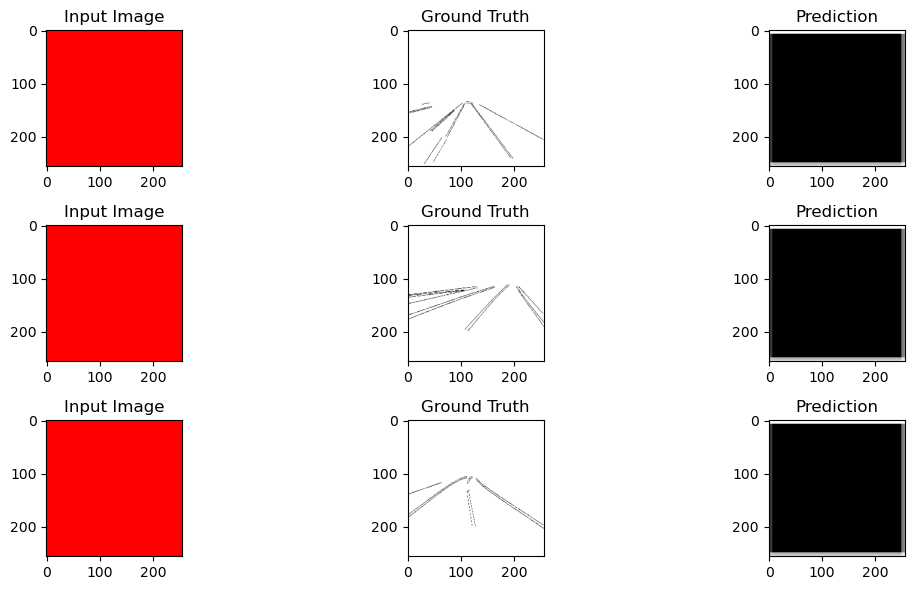

In [5]:
import matplotlib.pyplot as plt

def visualize_predictions(images, masks, predictions):
    plt.figure(figsize=(12, 6))
    for i in range(3):
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title('Input Image')

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Prediction')

    plt.tight_layout()
    plt.show()

predictions = model.predict(val_images)
visualize_predictions(val_images, val_masks, predictions)
